# Discretization Classification 2.0(Template) - KFold
## Author: Ming

## Import Package

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 


#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## 1.Load Data

In [2]:
# Load Data
data_name = "GiveMeSomeCredit"
#Fast: Japanese_Credit Australian_Original Germany_Original Japanese_Bankrupt 
#Slow: USA_Bankrupt

#Discretize Good: Kaggle Tsai Bankruptcy Australia JPNCredit
#
if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
 

## 2.Sampling

In [3]:
# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values

In [4]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 150000
特徵數量(不含Target) :: 10


In [5]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts)) #Major:1 ; minor2

{0: 139974, 1: 10026}

## Discretization_Python
Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [6]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            replace_coloumn.sort()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## Discretization Utility

In [7]:
class Discretization_utility:
    def __init__(self, continuous_data, discretize_coloumn):
        self.continuous_data_dataframe = continuous_data
        self.discretize_coloumn = discretize_coloumn

    # Deprecated
#     def SelectFeatures(self): ##Split Specific to Discretize
#         idx_IN_columns = self.discretize_coloumn
#         idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
#         selectData_list = self.training_data[:,idx_IN_columns]
#         disSelectData_list = self.training_data[:,idx_OUT_columns]
#         return selectData_list , disSelectData_list
    
    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.continuous_data_dataframe)[1]) if i not in idx_IN_columns]
        selectData_list = self.continuous_data_dataframe.iloc[:,idx_IN_columns]
        disSelectData_list = self.continuous_data_dataframe.iloc[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
    
    def PrintFirstFiveData(self,data,dataname): ##Split Specific to Discretize
        #print("["+str(dataname)+"]")
        #print(data.head(5))
        return 0
     

## Discretization with R
R package'Discretization'

In [8]:
class Discretization_rpy2:
    ## Input:X_train,y_train,X_test,y_test,discretize_coloumn,method
    ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe
    
    def discretize(X_train,y_train,X_test,y_test,discretize_coloumn,method):

        # Declare Discretizer_rpy2 (Select Continuous Feature, PrintFirstFive)
        discretize_train = Discretization_utility(X_train,discretize_coloumn)

        # Select Continuous Feature (Training Data Continuous Feature)
        X_train_continuousData_list, X_train_catrgorialData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns


        # Convert data to Dataframe for R Package "Discretization"
        ## R 'Discretization' require Continuous Data(X_Train_SelectData) and Target(y_Train) in the last column
        X_train_continuousData_dataframe = pd.DataFrame(X_train_continuousData_list)
        y_train_dataframe = pd.DataFrame(y_train)

        # Combine Select Continuous with Target
        X_y_train_continuousData_dataframe = pd.concat([X_train_continuousData_dataframe, y_train_dataframe],axis=1)
        X_y_train_continuousData_dataframe.columns = range(X_y_train_continuousData_dataframe.shape[1]) #Reshape for column index
        discretize_train.PrintFirstFiveData(X_y_train_continuousData_dataframe,"X_y_train_continuousData_dataframe")


        # Import R Package
        discretization = importr("discretization")
        disc_Topdown = robjects.r("disc.Topdown")

        print("-------------------------------"+method+" -----------------------------")

        # Discretize (R Package)
        ## Input: pandas.DataFrame  Output: rpy2.DataFrame
        if method == 'MDLP_R':
            X_y_train_disData_rpy2dataframe = discretization.mdlp(X_y_train_continuousData_dataframe)
        elif method == 'CAIM_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=1)
        elif method == 'ChiMerge_R':
            X_y_train_disData_rpy2dataframe = discretization.chiM(X_y_train_continuousData_dataframe, alpha = 0.05)
        elif method == 'CACC_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=2)
        elif method == 'Chi2_R':
            X_y_train_disData_rpy2dataframe = discretization.chi2(X_y_train_continuousData_dataframe,0.5,0.05)

        # Transfer rpy2.DataFrame to pandas.DataFrame
        X_y_train_disData_dataframe = pandas2ri.ri2py(X_y_train_disData_rpy2dataframe[1])
        discretize_train.PrintFirstFiveData(X_y_train_disData_dataframe,"X_y_train_disData_dataframe")


        # Select the data(without target) in Combine_X_y_train_dis_dataframe 
        X_train_disData_dataframe = X_y_train_disData_dataframe.iloc[:,:-1]
        discretize_train.PrintFirstFiveData(X_train_disData_dataframe,"X_train_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_train_categorialData_dataframe = pd.DataFrame(X_train_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_train_categorialData_dataframe,"X_train_categorialData_dataframe")            
        Discretize_X_train_dataframe = pd.concat([X_train_disData_dataframe, X_train_categorialData_dataframe],axis = 1)
        Discretize_X_train_dataframe.columns = range(Discretize_X_train_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_train_dataframe,"Discretize_X_train_dataframe")


        # --------------------------------------Discretize Testing Data----------------------------------------------------

        # Enable Cutpoint for X_test (No Target)

        ## Declare Discretization_utility
        discretize_test = Discretization_utility(X_test,discretize_coloumn)

        ## Select Continuous Feature (Testing Data Continuous Feature)
        ## Return: List of data
        X_test_continuousData_list, X_test_catrgorialData_list  = discretize_test.SelectFeatures() #Devide Discretize Coloumns


        ## Prepare X_test to enable cutpoint
        X_test_continuousData_dataframe  = pd.DataFrame(X_test_continuousData_list)
        discretize_train.PrintFirstFiveData(X_test_continuousData_dataframe,"X_test_continuousData_dataframe")


        ## Get Cutpoint (Transfer to numpy array)
        cutpoint_bins = X_y_train_disData_rpy2dataframe[0]
        #cutpoint_bins = np.array(cutpoint)
        #print("Original Cutbins")
        #print(cutpoint_bins)


        ## Declare dataframe for store data after discretize
        X_test_disData_dataframe = pd.DataFrame()

        # Iterate the cutbin to pd.cut the data
        for idx, val in enumerate(X_test_continuousData_dataframe):
            if cutpoint_bins[idx][0] == "All":
                #print(str(idx)+"_ALL")
                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins =1 , labels = [1],include_lowest=True )    
            else:        
                #print(str(idx)+"_NOTALL")
                cutpoint_bins[idx] = np.sort(cutpoint_bins[idx])
                #print(type(cutpoint_bins[idx]))
                cutpoint_with_infiniti = np.insert (np.insert(cutpoint_bins[idx],0, (-np.inf),0),len(cutpoint_bins[idx])+1,(np.inf))
                cutpoint_labels = list(range(1, len(cutpoint_with_infiniti)))
                #print(cutpoint_labels)

                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins = cutpoint_with_infiniti,labels=cutpoint_labels,include_lowest=True)
        discretize_train.PrintFirstFiveData(X_test_disData_dataframe,"X_test_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_test_categorialData_dataframe = pd.DataFrame(X_test_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_test_categorialData_dataframe,"X_test_categorialData_dataframe")

        Discretize_X_test_dataframe = pd.concat([X_test_disData_dataframe, X_test_categorialData_dataframe],axis=1)
        Discretize_X_test_dataframe.columns = range(Discretize_X_test_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_test_dataframe,"Discretize_X_test_dataframe")


        # Convert Target to Dataframe
        y_train_dataframe = pd.DataFrame(y_train)
        y_test_dataframe = pd.DataFrame(y_test)
        
        return Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe


## KFoldFuntion

In [9]:
class KFoldFuntion:
    # classifier, 
    # linear_svc,'linear_svc','','None','None','Dis-None', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, discretization_method, fs_method, method_order, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.discretization_method = discretization_method  # (None, MDLP, CAIM)
        self.fs_method = fs_method  # (None, C4.5, PCA, GA)
        self.method_order = method_order # (None-None, Dis-None, Dis-FS, FS-None, FS-Dis)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        # Main function
        ## Cross Validation, Discretization, (Feature Selection), Classifier
        
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            # Convert to Dataframe
            X_train_dataframe = pd.DataFrame(X_train)
            X_test_dataframe  = pd.DataFrame(X_test)
            y_train_dataframe = pd.DataFrame(y_train)
            y_test_dataframe  = pd.DataFrame(y_test)
            
            # Decide the process order (Dis-FS or FS-None)
            first_method, second_method = self.method_order.split('-')
            
            # Pre-Proecessing
            if first_method== 'Dis' and first_method != 'None':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif first_method== 'FS':
                print("Feature Selection")
                
            if second_method== 'Dis' and second_method != 'None':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif second_method== 'FS':
                print("Feature Selection")
            
          
            # Feature Preprocessing (Discretization, Feature Selection)


            # Discretization()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, discretization_method
            ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe

            # Feature Selection()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, method
            ## Output: X_train_dataframe,X_test_dataframe,y_train_dataframe,y_test_dataframe


            # Prediction (Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe)
            predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,
                                                    X_test_dataframe,y_test_dataframe)
            self.StoreFoldResult(y_test_dataframe,predictions,proba)
                
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        
        # Convert Dataframe column from int to str (for xgboost)
        X_train_dataframe.columns = X_train_dataframe.columns.astype(str)
        y_train_dataframe.columns = y_train_dataframe.columns.astype(str)
        X_test_dataframe.columns = X_test_dataframe.columns.astype(str)
        y_test_dataframe.columns = y_test_dataframe.columns.astype(str)
        
        # Convert Dataframe type from int to float (some classifier doesn't accept different dtype in same dataframe)
        X_train_dataframe = X_train_dataframe.astype('float')
        y_train_dataframe = y_train_dataframe.astype('float')
        X_test_dataframe = X_test_dataframe.astype('float')
        y_test_dataframe = y_test_dataframe.astype('float')
        
        
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe["0"].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{discretization_method}-{fs_method}-({method_order})-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,discretization_method=self.discretization_method,fs_method=self.fs_method,method_order=self.method_order,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [10]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2):
    # Compare different Preprocessing (Dis-FS) figure
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    result_10times_CACC_mean =  np.around( np.mean(result_10times_CACC, axis=0), decimals=3)
    result_10times_Chi2_mean =  np.around( np.mean(result_10times_Chi2, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP_R')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM_R')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_R')
    rects5 = ax.bar(x +width*4, result_10times_CACC_mean, width, label='CACC_R')
    rects6 = ax.bar(x +width*5, result_10times_Chi2_mean, width, label='Chi2_R')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [11]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [12]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

## Start Classify

## Run 10 Times

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarn

Mean Accuracy: 0.9324199999999999
Mean Accuracy[0.9324666666666667, 0.9307666666666666, 0.9322, 0.9328666666666666, 0.9338]
Mean Auc: 0.7058339988983275
Mean Auc[0.6981551057131861, 0.7085988306450564, 0.7207317938810957, 0.6940232311145158, 0.7076610331377842]
Mean TypeII: 0.9770674737724601
Mean TypeII[0.975597609561753, 0.9765967820575329, 0.9766517635370094, 0.978894472361809, 0.9775967413441955]
Mean TypeI: 0.002436267534945253
Mean TypeI[0.0023935410117176337, 0.0026476797023149306, 0.002429699503340837, 0.002356301320956801, 0.0023541161363960623]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

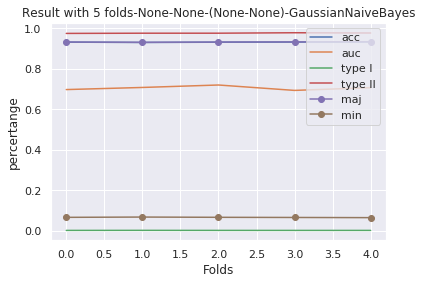

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9335666666666667
Mean Accuracy[0.9337666666666666, 0.9351333333333334, 0.9322, 0.9331666666666667, 0.9335666666666667]
Mean Auc: 0.6962188895250929
Mean Auc[0.6964883243664666, 0.6992000064927407, 0.6994172920555531, 0.6954486434704437, 0.6905401812402608]
Mean TypeII: 0.9661523833103584
Mean TypeII[0.9656739020696617, 0.9523809523809523, 0.9741589468551926, 0.9551060680809077, 0.9834420471650778]
Mean TypeI: 0.0019858045284575796
Mean TypeI[0.002641064991612834, 0.002354956112181546, 0.001288060395720777, 0.002466664283416151, 0.0011782768593565894]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------
Mean Accuracy: 0.8978066666666666
Mean Accuracy[0.8971, 0.8971666666666667, 0.8947, 0.8985666666666666, 0.9015]
Mean Auc: 0.6117692343451743
Mean Auc[0.6151482257075408, 0.6120604381142806, 0.6097315022998445, 0.6073854792749321, 0.6145205263292733]
Mean TypeII: 0.7204162619531573
Mean TypeII[0.7147087857847977, 0.7169715447154471, 0.7223611805902952, 0.7295690936106983, 0.7184707050645481]
Mean TypeI: 0.05790979710093486
Mean TypeI[0.05859011939658254, 0.05971746575342466, 0.06124781257812221, 0.05610950287695222, 0.053884084899592656]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

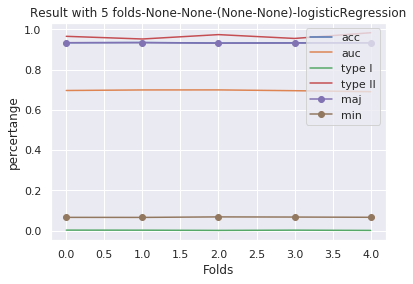

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Mean Accuracy: 0.9218866666666667
Mean Accuracy[0.9160666666666667, 0.924, 0.9234333333333333, 0.9252333333333334, 0.9207]
Mean Auc: 0.7726325295310289
Mean Auc[0.7635762426678553, 0.7775652931521481, 0.7738458627328103, 0.7752213686211501, 0.7729538804811806]
Mean TypeII: 0.7917617576728384
Mean TypeII[0.7567435017165277, 0.819647355163728, 0.8129388164493481, 0.795582948125321, 0.7738961669092673]
Mean TypeI: 0.027023328841261518
Mean TypeI[0.034869997496513, 0.023308941638407996, 0.024137684781832463, 0.02473888710654832, 0.028061133183005835]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

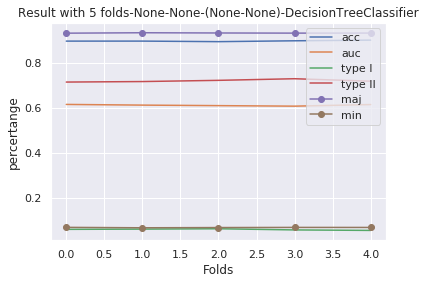

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

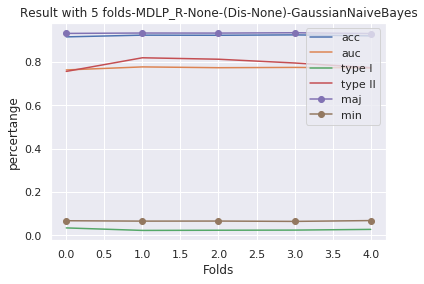

Discretization
-------------------------------CAIM_R -----------------------------
Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Mean Accuracy: 0.9333600000000001
Mean Accuracy[0.9320333333333334, 0.9331, 0.9347666666666666, 0.9332666666666667, 0.9336333333333333]
Mean Auc: 0.7692091884699905
Mean Auc[0.7722472383348438, 0.7620940807241116, 0.7676560893944322, 0.7773620616642014, 0.7666864722323639]
Mean TypeII: 0.9125377906602651
Mean TypeII[0.9276930644367929, 0.90963554667998, 0.9045899948427024, 0.9109055501460565, 0.9098647971957937]
Mean TypeI: 0.006042811137934654
Mean TypeI[0.005470733364322237, 0.006607850841161553, 0.007234239692099355, 0.004687611822801117, 0.006213619969289005]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Mean Accuracy: 0.3554133333333333
Mean Accuracy[0.5075, 0.0696, 0.5641666666666667, 0.5658666666666666, 0.06993333333333333]
Mean Auc: 0.7505657283846899
Mean Auc[0.7462917735191894, 0.7574464799479459, 0.7414256601949168, 0.7397135477666958, 0.7679511804947018]
Mean TypeII: 0.12250026607124978
Mean TypeII[0.17989690721649484, 0.0014858841010401188, 0.20845771144278608, 0.22216748768472908, 0.000493339911198816]
Mean TypeI: 0.6821288713729272
Mean TypeI[0.514112615823236, 0.9974268253457703, 0.4521614862450875, 0.44951734000715055, 0.9974260894433918]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Mean Accuracy: 0.8991199999999999
Mean Accuracy[0.8962333333333333, 0.8973333333333333, 0.9013, 0.9014666666666666, 0.8992666666666667]
Mean Auc: 0.6146312260086397
Mean Auc[0.6131407189099497, 0.6156431998809911, 0.6101385519545658, 0.6245280412136971, 0.6097056180839949]
Mean TypeII: 0.7244872909625334
Mean TypeII[0.727810650887574, 0.7176128093158661, 0.7331943720687858, 0.7065598397596394, 0.7372587827808016]
Mean TypeI: 0.05621882827466455
Mean TypeI[0.05852280852280852, 0.05730341100254125, 0.05533990954738079, 0.05517266007213513, 0.05475535222845706]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

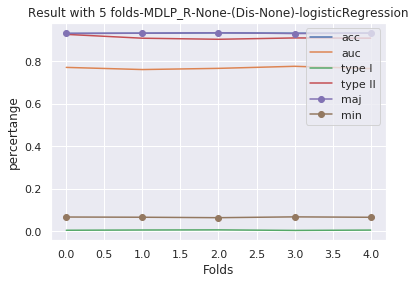

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


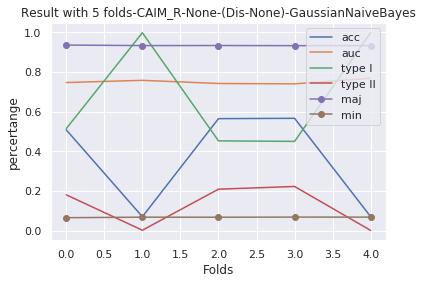

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

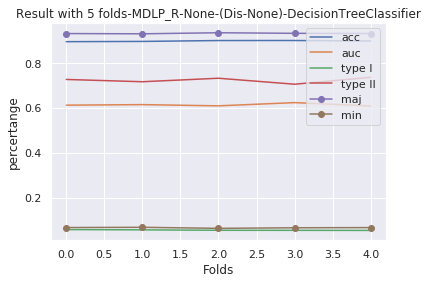

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
Discretization
-------------------------------CAIM_R -----------------------------
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9335666666666667
Mean Accuracy[0.9339333333333333, 0.9351666666666667, 0.9343, 0.9306333333333333, 0.9338]
Mean Auc: 0.7820223993004831
Mean Auc[0.7882846019729943, 0.7836428041568754, 0.7805959081814953, 0.7746475839364605, 0.78294109825459]
Mean TypeII: 0.8227741128383048
Mean TypeII[0.8211100099108027, 0.821337417049515, 0.8251143873919674, 0.8223901747756259, 0.8239185750636132]
Mean TypeI: 0.012259118719818432
Mean TypeI[0.01161460939175184, 0.01198245426340002, 0.012413940712731424, 0.01219380984829466, 0.013090779382914215]
Discretization


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


-------------------------------CAIM_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), se

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


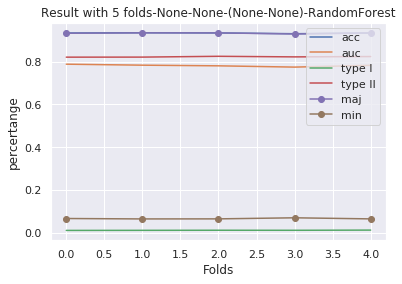

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.9333466666666667
Mean Accuracy[0.9321666666666667, 0.9356333333333333, 0.9351, 0.9321333333333334, 0.9317]
Mean Auc: 0.763134539506283
Mean Auc[0.7607860148320132, 0.7627687045658522, 0.7630759555253432, 0.7632631530090325, 0.7657788695991735]
Mean TypeII: 0.9783581308256923
Mean TypeII[0.9743463246176616, 0.9768399382398353, 0.9698672114402451, 0.9887420460107684, 0.9819951338199513]
Mean TypeI: 0.0013428900046979493
Mean TypeI[0.0021449254638401315, 0.0011761770681113447, 0.0017117181370800941, 0.0005723074721894338, 0.0011093218822687421]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Mean Accuracy: 0.9262466666666667
Mean Accuracy[0.926, 0.9253, 0.9275333333333333, 0.9253, 0.9271]
Mean Auc: 0.7724422937288085
Mean Auc[0.7769700183605229, 0.7721811826757815, 0.7661517458288334, 0.7688892528435222, 0.7780192689353818]
Mean TypeII: 0.8239153548241832
Mean TypeII[0.8201295465869457, 0.8519980266403552, 0.8221768012263669, 0.7997025285076846, 0.8255698711595639]
Mean TypeI: 0.02001778550290336
Mean TypeI[0.020505126281570394, 0.018374861473563795, 0.020147630424704917, 0.02244219704820784, 0.018619112286469872]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

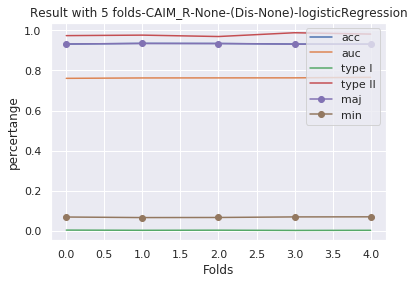

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packa

Mean Accuracy: 0.9371866666666667
Mean Accuracy[0.9389666666666666, 0.9365, 0.9381333333333334, 0.9363, 0.9360333333333334]
Mean Auc: 0.864328844949234
Mean Auc[0.8633287839616302, 0.8628129576022429, 0.8687410629161981, 0.8568563873528718, 0.8699050329132268]
Mean TypeII: 0.812407210708205
Mean TypeII[0.8205928237129485, 0.8031418753068238, 0.8136456211812627, 0.8183603338242513, 0.8062953995157385]
Mean TypeI: 0.009130319102907822
Mean TypeI[0.009010934216618584, 0.009619854808139327, 0.009202453987730062, 0.008725816257197011, 0.009092536244854125]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

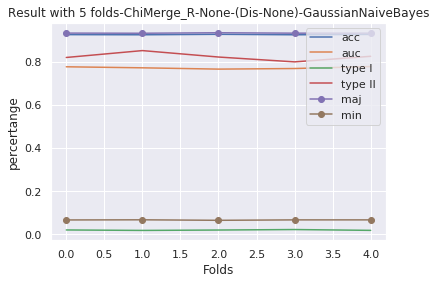

Discretization
-------------------------------CACC_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  

Mean Accuracy: 0.9053533333333335
Mean Accuracy[0.9093333333333333, 0.9032, 0.9083333333333333, 0.9076, 0.8983]
Mean Auc: 0.6056815894525863
Mean Auc[0.6060259799865401, 0.6019710721987728, 0.5971030407111524, 0.6018183639157173, 0.6214894904507495]
Mean TypeII: 0.7391804105060462
Mean TypeII[0.7417283950617284, 0.74800796812749, 0.7568373943311785, 0.7488744372186094, 0.7004538577912254]
Mean TypeI: 0.04847084130495486
Mean TypeI[0.04353887399463807, 0.05008573878250929, 0.043874379220408016, 0.045534088068283275, 0.05932112645893565]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

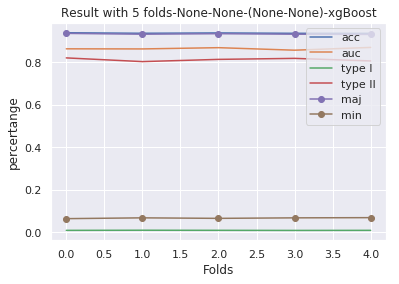

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

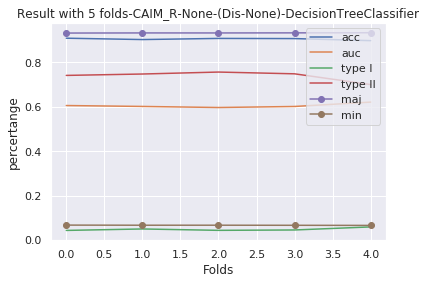

-------------------------------CACC_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs'

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------MDLP_R -----------------------------
Mean Accuracy: 0.9335000000000001
Mean Accuracy[0.9321, 0.9320333333333334, 0.9350333333333334, 0.9353666666666667, 0.9329666666666667]
Mean Auc: 0.7550356919201893
Mean Auc[0.7141595095772068, 0.7709275342241749, 0.7638495650340744, 0.7597817910925061, 0.7664600596729844]
Mean TypeII: 0.9250937781060149
Mean TypeII[0.975609756097561, 0.910958904109589, 0.9093686354378818, 0.9120822622107969, 0.9174493326742462]
Mean TypeI: 0.004978138730525298
Mean TypeI[0.0013237924865831842, 0.006331377879524968, 0.005813953488372093, 0.0058813045802887185, 0.005540265217857526]
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  

Mean Accuracy: 0.84314
Mean Accuracy[0.8339, 0.8554333333333334, 0.8329, 0.8627333333333334, 0.8307333333333333]
Mean Auc: 0.7474226995078628
Mean Auc[0.7415299598803458, 0.7477719896980126, 0.7420552097577203, 0.7532777787522869, 0.7524785594509488]
Mean TypeII: 0.4932874152294809
Mean TypeII[0.4847560975609756, 0.5073818897637795, 0.4764033780427223, 0.5274499743458184, 0.47044573643410853]
Mean TypeI: 0.13279183810984477
Mean TypeI[0.14372859589041095, 0.11820652173913043, 0.14485296744917284, 0.11015650065951303, 0.14701460481099657]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

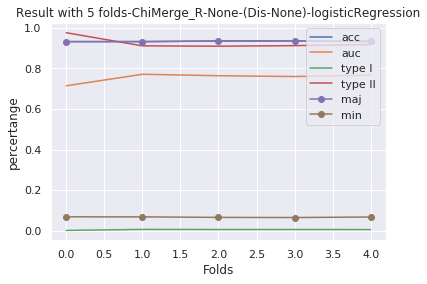

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


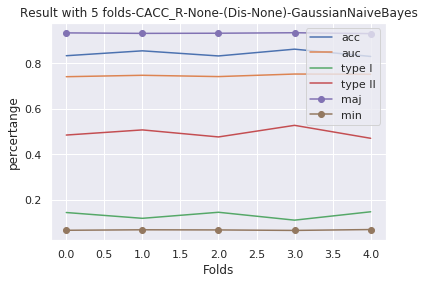

Discretization
-------------------------------Chi2_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.8974666666666666
Mean Accuracy[0.9002666666666667, 0.8965333333333333, 0.8973, 0.8962333333333333, 0.897]
Mean Auc: 0.6138411108139936
Mean Auc[0.6165778862379587, 0.61057859121702, 0.6127684774473573, 0.6121816418472174, 0.6170989573204148]
Mean TypeII: 0.7171572334008147
Mean TypeII[0.7153806847215125, 0.7265388496468214, 0.7173162308830784, 0.7189798921039725, 0.7075705096486887]
Mean TypeI: 0.05851145315508751
Mean TypeI[0.05676996041792961, 0.05939039189092726, 0.05816322882779824, 0.05890347269410965, 0.05933021194467279]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

Mean Accuracy: 0.93312
Mean Accuracy[0.9332666666666667, 0.9319, 0.9343, 0.9330333333333334, 0.9331]
Mean Auc: 0.5228991996559508
Mean Auc[0.36119282518519613, 0.6264078671467705, 0.6312180200957803, 0.35827022072534354, 0.6374070651266632]
Mean TypeII: 0.9954142141887046
Mean TypeII[0.9950074887668497, 0.9970559371933267, 0.9969450101832994, 0.9940417080436942, 0.9940209267563528]
Mean TypeI: 0.0003714694494697004
Mean TypeI[0.0003214630138943458, 0.0003933910306845004, 0.0004636895420174062, 0.0002501250625312656, 0.0004286785982209838]
Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

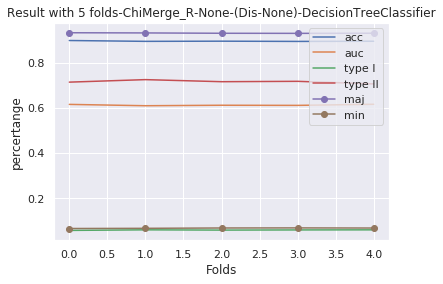

In [ ]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()
MultinomialNaiveBayes = MultinomialNB()
ComplementNaiveBayes = ComplementNB()
lboost = LogitBoost()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
    classifier_result_list = []
    
    for idx,classifi in enumerate(classifier_list):
        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            result_10times_CACC = []
            result_10times_Chi2 = []
            runnung_time_list = []

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'None','None','None-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIM_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_CACC = KFoldFuntion(clf, clf_name, 'CACC_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CACC.append(result_eachtimes_CACC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_Chi2 = KFoldFuntion(clf, clf_name, 'Chi2_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_Chi2.append(result_eachtimes_Chi2)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CACC,"CACC_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_Chi2,"Chi2_R",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))
        result_list.append(np.mean(result_10times_CACC, axis=0))
        result_list.append(np.mean(result_10times_Chi2, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP_R','CAIM_R','ChiMerge_R','CACC_R','Chi2_R'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{clf_name}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,clf_name=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    

# ---------------MultiThread: First Version---------------
# thread_start_time = time.time()

# t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
# t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
# t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
# t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
# t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
# t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
# t6 = Thread(target=run10times,args=(mlp,"mlp"))
# t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
# t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))
# t9 = Thread(target=run10times,args=(lboost,"LogitBoost"))
# t10 = Thread(target=run10times,args=(ada,"AdaBoost"))
# t11 = Thread(target=run10times,args=(knn,"KNN"))

# #thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t0]
# #thread_list = [t8]
# thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
# #thread_list = [t11,t10,t9,t7,t8]

# #程式開始
# for item in thread_list:
#     item.start()
# print("\n程式開始")


# #程式結束
# for item in thread_list:
#     item.join()
# print("\n程式結束")

# thread_end_time = time.time()  
# print("First Version time :", thread_end_time - thread_start_time)  


# ---------------MultiThread: Second Version---------------

t0=[svmlinear,"svmlinear"]
t1=[linear_svc,"linear_svc"]
t2=[svmrbf,"svmrbf"]
t3=[DecisionTreeClassifier,"DecisionTreeClassifier"]
t4=[RandomForest,"RandomForest"]
t5=[logisticRegression,"logisticRegression"]
t6=[mlp,"mlp"]
t7=[xgBoost,"xgBoost"]
t8=[GaussianNaiveBayes,"GaussianNaiveBayes"]
t9=[lboost,"LogitBoost"]
t10=[ada,"AdaBoost"]
t11=[knn,"KNN"]

from multiprocessing.dummy import Pool
if __name__ == '__main__':
    thread_start_time = time.time()
    pool = Pool()
    ##### Parameter: [1,2,3,4,5];  [(knn,"KNN"),(3,4)]
    #pool.starmap(run10times, [(knn,"KNN"),(lboost,"LogitBoost")])  # work in one thread
    pool.starmap_async(run10times, [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]).get()
    #task = [(knn,"KNN"),(lboost,"LogitBoost"),(ada,"AdaBoost")]
#     with pool as p:
#         pool.starmap_async(run10times, (knn,"KNN")).get()
    pool.close()  
    #pool.join()    
    thread_end_time = time.time()  
    print("Second Version time :", thread_end_time - thread_start_time)  

#############################################################################YEE

## Record Result

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))